In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
import argparse
import torch
%matplotlib inline

cuda=True if torch.cuda.is_available() else False
xfile = 'mnist2500_X.txt'
yfile = 'mnist2500_labels.txt'

if cuda:
    print("set use cuda")
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
else:
    torch.set_default_tensor_type(torch.DoubleTensor)


def Hbeta_torch(D, beta=1.0):
    P = torch.exp(-D.clone() * beta)
    sumP = torch.sum(P)
    H = torch.log(sumP) + beta * torch.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p_torch(X, tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """
    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape

    sum_X = torch.sum(X*X, 1)
    D = torch.add(torch.add(-2 * torch.mm(X, X.t()), sum_X).t(), sum_X)

    P = torch.zeros(n, n)
    beta = torch.ones(n, 1)
    logU = torch.log(torch.tensor([perplexity]))
    n_list = [i for i in range(n)]

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        # there may be something wrong with this setting None
        betamin = None
        betamax = None
        Di = D[i, n_list[0:i]+n_list[i+1:n]]

        (H, thisP) = Hbeta_torch(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while torch.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].clone()
                if betamax is None:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].clone()
                if betamin is None:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta_torch(Di, beta[i])

            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, n_list[0:i]+n_list[i+1:n]] = thisP

    # Return final P-matrix
    return P


def pca_torch(X, no_dims=50):
    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - torch.mean(X, 0)

    (l, M) = torch.eig(torch.mm(X.t(), X), True)
    # split M real
    for i in range(d):
        if l[i, 1] != 0:
            M[:, i+1] = M[:, i]
            i += 1

    Y = torch.mm(X, M[:, 0:no_dims])
    return Y


def tsne(X, no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """
    # Initialize variables
    X = pca_torch(X, initial_dims)
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = torch.randn(n, no_dims)
    dY = torch.zeros(n, no_dims)
    iY = torch.zeros(n, no_dims)
    gains = torch.ones(n, no_dims)

    # Compute P-values
    P = x2p_torch(X, 1e-5, perplexity)
    P = P + P.t()
    P = P / torch.sum(P)
    P = P * 4.    # early exaggeration
    print("get P shape", P.shape)
    P = torch.max(P, torch.tensor([1e-21]))

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = torch.sum(Y*Y, 1)
        num = -2. * torch.mm(Y, Y.t())
        num = 1. / (1. + torch.add(torch.add(num, sum_Y).t(), sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / torch.sum(num)
        Q = torch.max(Q, torch.tensor([1e-12]))

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = torch.sum((PQ[:, i] * num[:, i]).repeat(no_dims, 1).t() * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum

        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)).double() + (gains * 0.8) * ((dY > 0.) == (iY > 0.)).double()
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - torch.mean(Y, 0)

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = torch.sum(P * torch.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")

    X = np.loadtxt(xfile)
    X = torch.Tensor(X)
    labels = np.loadtxt(yfile).tolist()

    # confirm that x file get same number point than label file
    # otherwise may cause error in scatter
    assert(len(X[:, 0])==len(X[:,1]))
    assert(len(X)==len(labels))

    with torch.no_grad():
        Y = tsne(X, 2, 50, 20.0)

    if cuda:
        Y = Y.cpu().numpy()

    pyplot.scatter(Y[:, 0], Y[:, 1], 1, labels)
    pyplot.show()


set use cuda
Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.


OSError: mnist2500_X.txt not found.

In [116]:
import os
import numpy as np
import argparse
import matplotlib.pyplot as plt

from torchvision import datasets,transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torchvision,torch

import datasets,utils

#cuda = True if torch.cuda.is_available() else False
cuda=False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
        nn.init.kaiming_normal_(m.weight)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

class Encoder_grey(nn.Module):
    def __init__(self,y_dim,z_dim):
        super(Encoder_grey,self).__init__()
        self.y_dim = y_dim
        self.z_dim = z_dim
        
        #add the gaussian noise on the image
        #self.gaosi = nn.Sequential(GaussianNoise(0.05), nn.Dropout2d(0.15)) 

        self.model=nn.Sequential(
            nn.Linear(784,1000),nn.LeakyReLU(),
            nn.Linear(1000,1000),nn.LeakyReLU(),
        )
        self.cat=nn.Sequential(
            nn.Linear(1000,y_dim),nn.Softmax(dim=1)
        )
        self.gauss=nn.Linear(1000,z_dim)
        
        self.apply(weights_init)
        
    def forward(self,x):
        x=x.view(x.shape[0],-1)
        x=self.model(x)
        y_cat = self.cat(x)
        z_gauss = self.gauss(x)

        return y_cat,z_gauss



dataset_name='mnist'
y_dim=10 if dataset_name not in ('cifar100') else 100 #number of classes for the data
z_dim= 2 if dataset_name in ('mnist','fashion_mnist') else 64#number of styles for the data
    
En=Encoder_grey(y_dim,z_dim).cuda()
#encoder_RGB=Encoder_RGB(y_dim,z_dim)
En.load_state_dict(torch.load('./state_dict/'+ dataset_name +'/encoder 10 64.pth'))

dataloader_train,dataloader_test=datasets.load_data_from('llp_aae',False, dataset_name, 128)

latent_z,fake_labels=[],[]
with torch.no_grad():
    for i, (imgs, labels) in enumerate(dataloader_test):
        imgs=imgs.cuda()
        fake_cat,fake_gauss = En(imgs)
        z=fake_gauss.detach().cpu().data.numpy()
        label_pred=fake_cat.detach().cpu().data.numpy()
        for j in range(imgs.shape[0]):
            #index=np.where(np.max(label_pred[j])==label_pred[j])[0][0]
            latent_z.append(z[j])
            #fake_labels.append(index)
            fake_labels.append(labels[j])
latent_z,fake_labels=np.array(latent_z),np.array(fake_labels)

#z=utils.swiss_roll(10000)              
                
plt.figure(figsize=(8, 8))
c=['dodgerblue','g','r','c','m','y','k','lime','gray','orange']
#c=['dodgerblue','limegreen','r','c','violet','gold','darkred','lime','darkgray','orange']

import matplotlib.patches as patches
rects=[patches.Rectangle((0,0),1,1,facecolor=i) for i in c]
latent_z=latent_z*5

for i in range(10):
    plt.figure(figsize=(8, 8))
    plt.scatter(latent_z[fake_labels == i][:, 0], latent_z[fake_labels == i][:, 1], label=str(i),s=5,marker='o',c=c[i])
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    plt.legend(rects, [str(i) for i in range(10)],loc="upper right")
    plt.savefig('./generated samples/'+ str(i) +'.png')
    plt.close()

<Figure size 576x576 with 0 Axes>

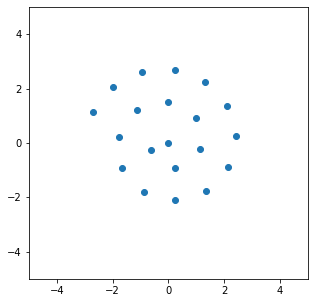

In [122]:
import os
import numpy as np
import argparse
import matplotlib.pyplot as plt

from torchvision import datasets,transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torchvision,torch

import datasets,utils

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
        nn.init.kaiming_normal_(m.weight)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

class Decoder_grey(nn.Module):
    def __init__(self,y_dim,z_dim, method, output_dim=1, input_size=28):
        super(Decoder_grey,self).__init__()
        if method=='aae':
            self.input_dim=z_dim
        else:
            self.input_dim=y_dim+z_dim
        self.z_dim=z_dim
        
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 1000), nn.LeakyReLU(),
            nn.Linear(1000, 1000), nn.LeakyReLU(),
            nn.Linear(1000, 784), nn.Tanh()
        )

        self.apply(weights_init)

    def forward(self, X):
        out = self.net(X)
        out=out.view(out.shape[0],-1,28,28)
        
        return out

dataset_name='mnist'
y_dim=10 if dataset_name not in ['cifar100'] else 100 #number of classes for the data
z_dim= 2#number of styles for the data
    
De=Decoder_grey(y_dim,z_dim,'llp_aae').cuda()
#encoder_RGB=Encoder_RGB(y_dim,z_dim)
De.load_state_dict(torch.load('./state_dict/'+ dataset_name +'/decoder 10 64.pth'))

#z=utils.swiss_roll(10000)              

def y_(i):
    if i==0:
        return torch.Tensor([[1,0,0,0,0,0,0,0,0,0] for i in range(121)]).cuda()
    elif i==1:
        return torch.Tensor([[0,1,0,0,0,0,0,0,0,0] for i in range(121)]).cuda()
    elif i==2:
        return torch.Tensor([[0,0,1,0,0,0,0,0,0,0] for i in range(121)]).cuda()
    elif i==3:
        return torch.Tensor([[0,0,0,1,0,0,0,0,0,0] for i in range(121)]).cuda()
    elif i==4:
        return torch.Tensor([[0,0,0,0,1,0,0,0,0,0] for i in range(121)]).cuda()
    elif i==5:
        return torch.Tensor([[0,0,0,0,0,1,0,0,0,0] for i in range(121)]).cuda()
    elif i==6:
        return torch.Tensor([[0,0,0,0,0,0,1,0,0,0] for i in range(121)]).cuda()
    elif i==7:
        return torch.Tensor([[0,0,0,0,0,0,0,1,0,0] for i in range(121)]).cuda()
    elif i==8:
        return torch.Tensor([[0,0,0,0,0,0,0,0,1,0] for i in range(121)]).cuda()
    elif i==9:
        return torch.Tensor([[0,0,0,0,0,0,0,0,0,1] for i in range(121)]).cuda()
    

z_1=[]
uni = []
for i in range(10):
    t=(np.arange(0.0, 1,0.5) / 10.0+i/10.0)
    uni=uni+list(t)
r = np.sqrt(uni) * 3.0
rad = np.pi * 5.0 * np.sqrt(uni)
x = r * np.cos(rad)
y = r * np.sin(rad)
plt.figure(figsize=(5,5))
plt.scatter(x,y)
plt.xlim(-5,5)
plt.ylim(-5,5)
z_1=[[i,j] for i,j in zip(x,y)]

z_2=[]

z_2=[]
for i in -np.arange(-4,4.1,0.8):
    for j in np.arange(-4,4.1,0.8):
        z_2.append([j,i])
        
        
z_swiss_roll=torch.Tensor(z_1).cuda()
z_gaussian_mixture=torch.Tensor(z_2).cuda()

inputs=torch.Tensor([]).cuda()
for i in range(10):
    inputs_1=torch.cat((y_(i),z_gaussian_mixture),dim=1)
    #inputs=torch.cat((inputs,inputs_1),dim=0)
    gen_imgs=De(inputs_1)
    save_image(gen_imgs,'./generated samples/sample'+ str(i) +'.png',nrow=11)

In [61]:
[1,2,3]+[]

[1, 2, 3]

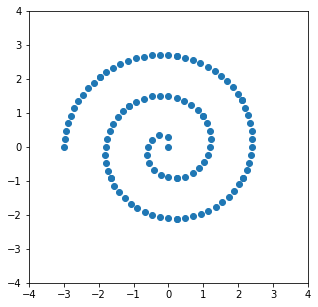

In [51]:
import numpy as np
import matplotlib.pyplot as plt


uni = []
for i in range(10):
    uni.append(np.arange(0.0, 1.1,0.1) / 10.0+i/10.0)
r = np.sqrt(uni) * 3.0
rad = np.pi * 5.0 * np.sqrt(uni)
x = r * np.cos(rad)
y = r * np.sin(rad)

plt.figure(figsize=(5,5))
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.scatter(x,y)

2

In [23]:
mean=0;std=0
for i in range(1):
    z=np.random.normal(0,1,(64,2))
    mean+=np.mean(z)
    std+=np.std(z,ddof=1)
print('mean=%d',mean/1)
print('std=%d',std/1)

import torch

real_gauss=torch.Tensor(z)
print(real_gauss[0])

mean=%d 0.005636597411463037
std=%d 0.9911351625335253
tensor([ 0.4755, -1.0189])


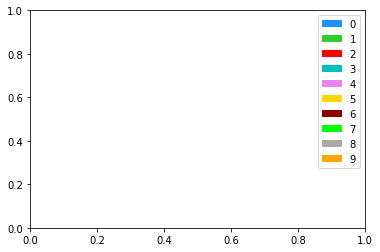

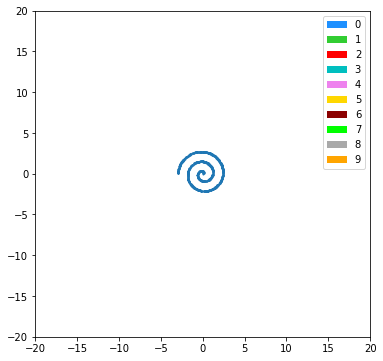

In [50]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gaussian_mixture(batch_size, n_dim=2, n_labels=10, x_var=0.5, y_var=0.1, label_indices=None):
    if n_dim % 2 != 0:
        raise Exception("n_dim must be a multiple of 2.")

    def sample(x, y, label, n_labels):
        shift = 1.4
        r = 2.0 * np.pi / float(n_labels) * float(label)
        new_x = x * np.cos(r) - y * np.sin(r)
        new_y = x * np.sin(r) + y * np.cos(r)
        new_x += shift * np.cos(r)
        new_y += shift * np.sin(r)
        return np.array([new_x, new_y]).reshape((2,))

    x = np.random.normal(0, x_var, (batch_size, n_dim // 2))
    y = np.random.normal(0, y_var, (batch_size, n_dim // 2))
    z = np.empty((batch_size, n_dim), dtype=np.float32)
    for batch in range(batch_size):
        for zi in range(n_dim // 2):
            if label_indices is not None:
                z[batch, zi*2:zi*2+2] = sample(x[batch, zi], y[batch, zi], label_indices[batch], n_labels)
            else:
                z[batch, zi*2:zi*2+2] = sample(x[batch, zi], y[batch, zi], np.random.randint(0, n_labels), n_labels)

    return z

def swiss_roll(batch_size, n_dim=2, n_labels=10, label_indices=None):
    def sample(label, n_labels):
        uni = np.random.uniform(0.0, 1.0) / float(n_labels) + float(label) / float(n_labels)
        r = np.sqrt(uni) * 3.0
        rad = np.pi * 5.0 * np.sqrt(uni)
        x = r * np.cos(rad)
        y = r * np.sin(rad)
        return np.array([x, y]).reshape((2,))

    z = np.zeros((batch_size, n_dim), dtype=np.float32)
    for batch in range(batch_size):
        for zi in range(n_dim // 2):
            if label_indices is not None:
                z[batch, zi*2:zi*2+2] = sample(label_indices[batch], n_labels)
            else:
                z[batch, zi*2:zi*2+2] = sample(np.random.randint(0, n_labels), n_labels)
    return z

def uniform(batch_size, n_dim=2, n_labels=10, minv=-1, maxv=1, label_indices=None):
    #  z = np.random.uniform(minv, maxv, (batch_size, n_dim)).astype(np.float32)
    def sample(label, n_labels):
        num = int(np.ceil(np.sqrt(n_labels)))
        size = (maxv-minv)*1.0/num
        x, y = np.random.uniform(-size/2, size/2, (2,))
        i = label / num
        j = label % num
        x += j*size+minv+0.5*size
        y += i*size+minv+0.5*size
        return np.array([x, y]).reshape((2,))

    z = np.empty((batch_size, n_dim), dtype=np.float32)
    for batch in range(batch_size):
        for zi in range(n_dim//2):
            if label_indices is not None:
                z[batch, zi*2:zi*2+2] = sample(label_indices[batch], n_labels)
            else:
                z[batch, zi*2:zi*2+2] = sample(np.random.randint(0, n_labels), n_labels)
    return z

def normal(batch_size, n_dim=2, n_labels=10, label_indices=None):
    return np.random.normal(size=(batch_size,2))

#z=gaussian_mixture(10000)*5
z=swiss_roll(1000)
#z=uniform(10000)*5
#z=normal(10000)*5

import matplotlib.patches as patches

c=['dodgerblue','limegreen','r','c','violet','gold','darkred','lime','darkgray','orange']
rects=[patches.Rectangle((0,0),1,1,facecolor=i) for i in c]

rect1 = patches.Rectangle((0,0),1,1,facecolor='#FF605E')
rect2 = patches.Rectangle((0,0),1,1,facecolor='#64B2DF')
plt.legend(rects, [str(i) for i in range(10)],loc="upper right")

plt.figure(figsize=(6,6))
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.scatter(z[:,0],z[:,1],s=1,marker='o')
plt.legend(rects, [str(i) for i in range(10)],loc="upper right")

In [23]:
np.random.uniform(0.0, 1.0)

0.17063499640391788